In [1]:
! pip install cmake==3.18
! pip install pykeops
! pip install gpytorch

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import gpytorch
import pykeops
print(gpytorch.__version__)
print(pykeops.__version__)

1.5.1
1.5


In [3]:
import sys
import os
import subprocess
import tarfile
import shutil
import types
import math
import pickle

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.autograd import grad
import gpytorch

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import boda
from boda.generator import plot_tools
from boda.common import constants

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn

from scipy import spatial
from scipy.cluster import hierarchy
from scipy.stats import spearmanr

In [4]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')

hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211108_083428__116627.tar.gz'

unpack_artifact(hpo_rec)

model_dir = './artifacts'

my_model = model_fn(model_dir)
my_model.cuda()
my_model.eval()

left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {left_flank.shape}')

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {right_flank.shape}')

Loaded model from 20211108_083428 in eval mode
Left flanking sequence shape: torch.Size([1, 4, 200])
Left flanking sequence shape: torch.Size([1, 4, 200])


In [5]:
class MyEnergy(torch.nn.Module):
    
    def __init__(self, model, left_flank, right_flank, bias_cell=None, bias_alpha=1.):
        super().__init__()
        
        self.model = model
        self.model.eval()
        
        self.register_buffer('left_flank', left_flank.to(model.device))
        self.register_buffer('right_flank', right_flank.to(model.device))
        
        self.bias_cell = bias_cell
        self.bias_alpha= bias_alpha
        
    def add_flanks(self, x):
        try:
            expand_left  = self.left_flank.expand(self.batch_size, -1, -1)
            expand_right = self.right_flank.expand(self.batch_size, -1, -1)
            return torch.cat([ expand_left, x, expand_right ], dim=-1)
        except (AttributeError, RuntimeError) as e:
            self.batch_size = x.shape[0]
            return self.add_flanks(x)
        
    def forward(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
                
        hook = self.model(hook)
        
        if self.bias_cell is not None:
            hook = hook[...,[ x for x in range(hook.shape[-1]) if x != self.bias_cell]].max(-1).values \
                     - hook[...,self.bias_cell].mul(self.bias_alpha)
        else:
            hook = boda.graph.utils.shannon_entropy(hook)

        return hook
    
    def encode(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
        
        hook = self.model.encode(hook)
        
        return hook
    
    def encode_and_decode(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
        
        hook = self.model.encode(hook)
        
        return hook, self.model.decode(hook)
    
    def encode_and_decode_and_pred(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
        
        ec = self.model.encode(hook)
        
        dc = self.model.decode(ec)
        
        pre= self.model.classify(dc)
        
        return ec, dc, pre

In [6]:
my_energy = MyEnergy(my_model, left_flank, right_flank, bias_cell=None, bias_alpha=1.)

In [7]:
data_module = getattr(boda.data, 'MPRA_DataModule')
data = data_module(datafile_path='gs://syrgoth/data/MPRA_ALL_HD_v2.txt', data_project=['BODA','UKBB'], padded_seq_len=600)
data.setup()

cell_type = 0

--------------------------------------------------

K562 | top cut value: 11.03, bottom cut value: -6.01
HepG2 | top cut value: 10.01, bottom cut value: -5.2
SKNSH | top cut value: 10.06, bottom cut value: -5.34

Number of examples discarded from top: 0
Number of examples discarded from bottom: 0

Number of examples available: 319561

--------------------------------------------------

Padding sequences...
Tokenizing sequences...
Creating train/val/test datasets...
--------------------------------------------------

Number of examples in train: 276121 (86.41%)
Number of examples in val:   15566 (4.87%)
Number of examples in test:  27874 (8.72%)

Excluded from train: 0 (0.0)%
--------------------------------------------------


In [8]:
print( len(data.chr_dataset_train) )
for batch in data.chr_dataset_train:
    x, y = batch
    print(x.shape)
    print(y.shape)
    break

264680
torch.Size([4, 600])
torch.Size([3])


In [9]:
def degeneracy_filter(in_tensor, max_degeneracy=1.):
    mode_check = in_tensor.cpu() == in_tensor.cpu().mode(dim=0).values
    return torch.tensor([ val < int(max_degeneracy*mode_check.shape[0]) for val in mode_check.sum(0) ])

In [10]:
X, Y = [ torch.stack(z, dim=0) for z in zip(*data.dataset_train) ]
X = X[:, :, 200:400]
Y = Y[:,cell_type]
print(X.shape)
print(Y.shape)

bsz = 128

enc_ = []
dec_ = []
pre_ = []

with torch.no_grad():
    for i in range((X.shape[0]//bsz)+1):
        X_batch = X[i*bsz:(i+1)*bsz]
        encoded, decoded, preds = my_energy.encode_and_decode_and_pred(X_batch)
        
        enc_.append(encoded.cpu())
        dec_.append(decoded.cpu())
        pre_.append(preds.cpu())
        
encoded = torch.cat(enc_, dim=0)
decoded = torch.cat(dec_, dim=0)
preds   = torch.cat(pre_, dim=0)

print(encoded.shape)
print(decoded.shape)
print(preds.shape)

torch.Size([276121, 4, 200])
torch.Size([276121])


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([276121, 2600])
torch.Size([276121, 936])
torch.Size([276121, 3])


Check encoder degeneracy.
proportion equal to mode


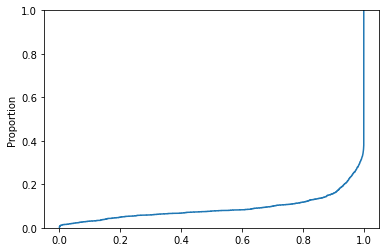

proportion different from mode


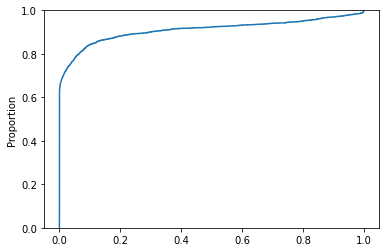

Check decoder degeneracy.
proportion equal to mode


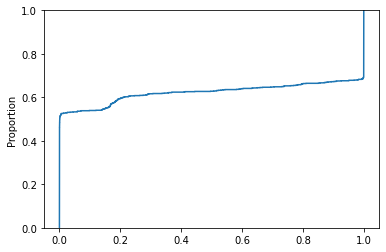

proportion different from mode


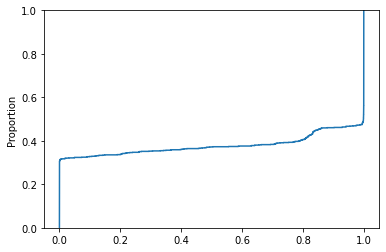

In [11]:
print("Check encoder degeneracy.")

with torch.no_grad():
    p = []
    t = 0
    mode_check = encoded.cpu() == encoded.cpu().mode(dim=0).values
    for i, val in enumerate(mode_check.sum(0)):
        p.append( (val.item() / mode_check.shape[0]) )
    p = np.array(p)

print('proportion equal to mode')
sns.ecdfplot(p)
plt.show()
print('proportion different from mode')
sns.ecdfplot(1-p)
plt.show()

print("Check decoder degeneracy.")

with torch.no_grad():
    p = []
    t = 0
    mode_check = decoded.cpu() == decoded.cpu().mode(dim=0).values
    for i, val in enumerate(mode_check.sum(0)):
        p.append( (val.item() / mode_check.shape[0]) )
    p = np.array(p)

print('proportion equal to mode')
sns.ecdfplot(p)
plt.show()
print('proportion different from mode')
sns.ecdfplot(1-p)
plt.show()

In [12]:
enc_filter = degeneracy_filter(encoded, 0.8)
print(f'encoder: {enc_filter.sum()} passed features')
dec_filter = degeneracy_filter(decoded, 0.8)
print(f'decoder: {dec_filter.sum()} passed features')

encoder: 306 passed features
decoder: 620 passed features


In [13]:
#train_x, train_y = decoded[:,dec_filter].cpu(), Y.cpu()
train_x, train_y = encoded[:,enc_filter].cpu(), Y.cpu()

#mean_x, std_x = train_x.mean(dim=0, keepdim=True), train_x.std(dim=0, keepdim=True)
#mean_y, std_y = train_y.mean(dim=0, keepdim=True), train_y.std(dim=0, keepdim=True)

#train_x, train_y = (train_x - mean_x) / std_x, (train_y - mean_y) / std_y

In [14]:
X, Y = [ torch.stack(z, dim=0) for z in zip(*data.chr_dataset_test) ]
X = X[:, :, 200:400]
Y = Y[:,cell_type]
print(X.shape)
print(Y.shape)

bsz = 128

enc_ = []
dec_ = []
pre_ = []

with torch.no_grad():
    for i in range((X.shape[0]//bsz)+1):
        X_batch = X[i*bsz:(i+1)*bsz]
        encoded_test, decoded_test, preds_test = my_energy.encode_and_decode_and_pred(X_batch)
        
        enc_.append(encoded_test.cpu())
        dec_.append(decoded_test.cpu())
        pre_.append(preds_test.cpu())
        
encoded_test = torch.cat(enc_, dim=0)
decoded_test = torch.cat(dec_, dim=0)
preds_test   = torch.cat(pre_, dim=0)

    
print(encoded_test.shape)
print(decoded_test.shape)
print(preds_test.shape)

torch.Size([26444, 4, 200])
torch.Size([26444])
torch.Size([26444, 2600])
torch.Size([26444, 936])
torch.Size([26444, 3])


In [15]:
#test_x, test_y = decoded_test[:,dec_filter].cpu(), Y.cpu()
test_x, test_y = encoded_test[:,enc_filter].cpu(), Y.cpu()

#test_x = (test_x - mean_x) / std_x
#test_y = (test_y - mean_y) / std_y

In [16]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.keops.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
model = ExactGPModel(train_x.cuda(), train_y.cuda(), likelihood).cuda()

In [17]:
%%time

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 20
pbar = tqdm(range(training_iter), desc='Steps', position=0, leave=True)
for i in pbar:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x.cuda())
    # Calc loss and backprop gradients
    loss = -mll(output, train_y.cuda())
    loss.backward()
    pbar.set_postfix(
        {'Loss': loss.item(),
         'lengthscale': model.covar_module.base_kernel.lengthscale.item(),
         'noise':model.likelihood.noise.item()}            
    )
    optimizer.step()

Steps:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)
Steps: 100%|██████████| 20/20 [11:48:31<00:00, 2125.59s/it, Loss=0.739, lengthscale=0.347, noise=0.149]  

CPU times: user 11h 44min 6s, sys: 14.6 s, total: 11h 44min 20s
Wall time: 11h 48min 31s


In [18]:
%%time

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x.cuda()))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

CPU times: user 2h 7min 41s, sys: 2.69 s, total: 2h 7min 44s
Wall time: 2h 8min 28s


In [19]:
mean

tensor([ 2.2123, -0.0387, -0.0672,  ...,  0.6971, -0.2118,  0.6959],
       device='cuda:0')

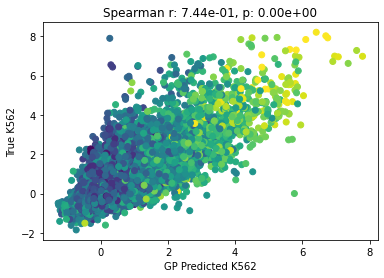

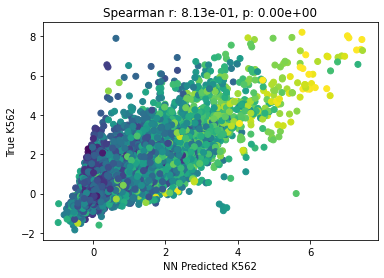

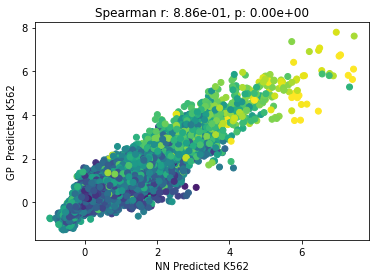

In [20]:
plt.scatter( mean.cpu().numpy(), test_y.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( mean.cpu().numpy(), Y.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Predicted K562")
plt.ylabel("True K562")
plt.show()

plt.scatter( preds_test[:,0].cpu().numpy(), test_y.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( preds_test[:,0].cpu().numpy(), Y.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("NN Predicted K562")
plt.ylabel("True K562")
plt.show()

plt.scatter( preds_test[:,0].cpu().numpy(), mean.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( preds_test[:,0].cpu().numpy(), mean.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("NN Predicted K562")
plt.ylabel("GP  Predicted K562")
plt.show()

In [21]:
from sklearn.decomposition import PCA

dim_red = PCA(n_components = 3)

seq_pca = dim_red.fit_transform(train_x.cpu().numpy())
seq_pca_test = dim_red.transform(test_x.cpu().numpy())

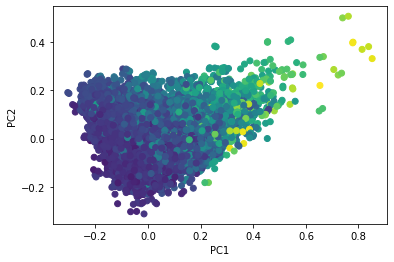

In [22]:
plt.scatter( seq_pca_test[:,0], seq_pca_test[:,1], c=test_y.cpu().numpy(), cmap='viridis' )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

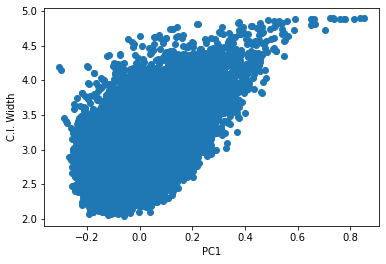

In [23]:
plt.scatter( seq_pca_test[:,0], (upper-lower).cpu().numpy() )
plt.xlabel("PC1")
plt.ylabel("C.I. Width")
plt.show()

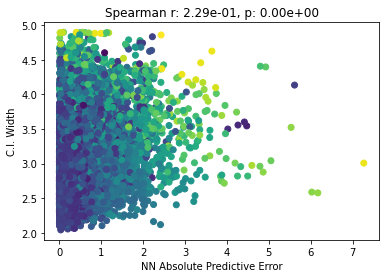

In [24]:
plt.scatter( (preds_test[:,0].cpu()-test_y.cpu()).abs().numpy(), (upper-lower).cpu().numpy(), c=Y.cpu(), cmap='viridis' )
corr, pval = spearmanr( (preds_test[:,0].cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("NN Absolute Predictive Error")
plt.ylabel("C.I. Width")
plt.show()

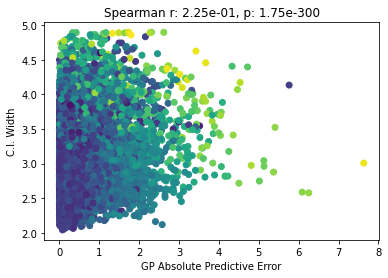

In [25]:
plt.scatter( (mean.cpu()-test_y.cpu()).abs().numpy(), (upper-lower).cpu().numpy(), c=Y.cpu(), cmap='viridis' )

corr, pval = spearmanr( (mean.cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Absolute Predictive Error")
plt.ylabel("C.I. Width")

plt.show()

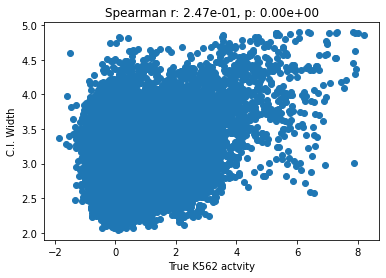

In [26]:
plt.scatter( test_y.cpu().numpy(), (upper-lower).cpu().numpy() )
corr, pval = spearmanr( test_y.cpu().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("True K562 actvity")
plt.ylabel("C.I. Width")
plt.show()

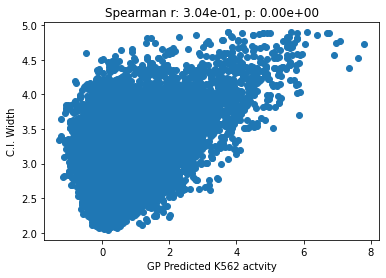

In [27]:
plt.scatter( mean.cpu().numpy(), (upper-lower).cpu().numpy() )
corr, pval = spearmanr( mean.cpu().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Predicted K562 actvity")
plt.ylabel("C.I. Width")
plt.show()